In [1]:
import os; os.chdir('..')
import sys; sys.path.extend(['.'])

In [2]:
from PIL import Image

import os
from PIL import Image
import argparse
from tqdm import tqdm
import torch
import torchvision.transforms.functional as TVF
import numpy as np
from distutils.dir_util import copy_tree
from training.networks import SynthesisLayer
from training.networks import PatchWiseSynthesisLayer
import dnnlib
from scripts.legacy import load_network_pkl

np.random.seed(42)
torch.manual_seed(42)

network_pkl = 'https://vision-cair.s3.amazonaws.com/alis/lhq1024-snapshot.pkl'
device = 'cuda'

with dnnlib.util.open_url(network_pkl) as f:
    G = load_network_pkl(f)['G_ema'].to(device) # type: ignore
    G.eval()
    G.progressive_growing_update(100000)

for res in G.synthesis.block_resolutions:
    block = getattr(G.synthesis, f'b{res}')
    if hasattr(block, 'conv0'):
        block.conv0.use_noise = False
    block.conv1.use_noise = False

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


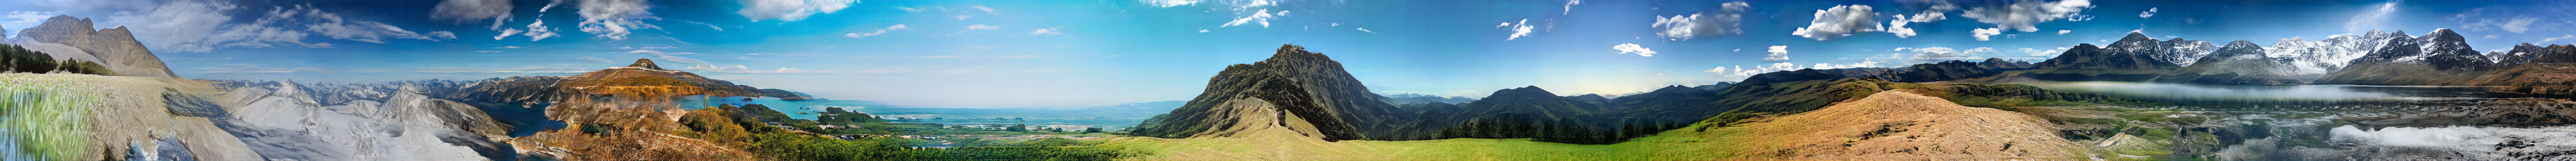

In [3]:
num_frames = 16
num_frames_per_w = G.synthesis_cfg.patchwise.w_coord_dist // 2
num_ws = num_frames // num_frames_per_w + 1
shifts = torch.arange(num_frames) * G.synthesis_cfg.patchwise.grid_size
w_range = 2 * num_frames_per_w * G.synthesis_cfg.patchwise.grid_size
max_shift = (num_frames_per_w * 2 - 1) * G.synthesis_cfg.patchwise.grid_size
zs = torch.randn(num_ws, G.z_dim).to(device) 
mode_idx = 0
modes_idx = (torch.ones(1, device=zs.device).repeat(num_ws).float() * mode_idx).long()
ws = G.mapping(zs, c=None, modes_idx=modes_idx)

z_mean = torch.randn(1000, G.z_dim).to(device)
ws_proto = G.mapping(z_mean, c=None, modes_idx=modes_idx[0]).mean(dim=0, keepdim=True)

# Truncating
truncation_factor = 1.0
ws = ws * truncation_factor + (1 - truncation_factor) * ws_proto

imgs = []
curr_w_idx = 1
curr_ws = ws[curr_w_idx].unsqueeze(0)
curr_ws_context = torch.stack([ws[curr_w_idx - 1].unsqueeze(0), ws[curr_w_idx + 1].unsqueeze(0)], dim=1)

for shift in shifts:
    if shift > 0 and shift % w_range == 0:
        curr_w_idx += 2
        curr_ws = ws[curr_w_idx].unsqueeze(0)
        curr_ws_context = torch.stack([ws[curr_w_idx - 1].unsqueeze(0), ws[curr_w_idx + 1].unsqueeze(0)], dim=1)

    curr_left_borders_idx = torch.zeros(1, device=zs.device).long() + (shift % w_range)
    img = G.synthesis(curr_ws, ws_context=curr_ws_context, left_borders_idx=curr_left_borders_idx, noise='const')
    imgs.append(img)

whole_img = torch.cat(imgs, dim=3)[0].clamp(-1, 1) * 0.5 + 0.5
TVF.resize(TVF.to_pil_image(whole_img), 256, interpolation=Image.LANCZOS)